In [1]:
library(data.table)
library("rpart")
library("rpart.plot")

In [2]:
setwd("Downloads")

## Growing of Tree
### Starting from the root node will always result in 2 child nodes.
- If X is Continuous, then select one data value to get the binary split. Left Node: Age <= 62.5, Right Node: Age > 62.5
- If X is Categorical (nominal), then will immediately result in 2 mutually exclusive subgroup. Left Node: Male, Right Node: Female
- If X is Categorical (ordinal), then have to obey order ranking when splitting. Left Node: {S,M}, Right Node: {L,XL}

### How CART determines which X variables to select as the splitting variable and the data value for the splitting point
#### - Continuous Y - SSE(Sum of Squared Errors)
Minimizing SSE is the criteria to obtain the optimal linear regression equation
#### - Categorical Y - Gini Index: Measure of node impurity. 
Best outcome is when all Y values in the node have the same category (100% pure)
Worst outcome is when all Y values are equally likely (50%)
General Principles in any measure of node impurity:
1. Existence of lowest impurity. Impurity measure = 0 means 100% pure node. Occurs when all Y values in the node are in the same category
2. Existence of highest impurity. Impurity measure = 1 means 100% impure node. Occurs when all Y values occur the same number of times in the node.

Example
- Impurity of {40% A, 60% B} > Impurity of {30% A, 70% B}
- Impurity of {40% A, 60% B} = Impurity of {60% A, 40% B}

### CART tree growing procedure
#### Categorical Y
1. Starting with all data at root node, compute proportions of Y
2. Consider a binary split and compute the weighted average gini index of the 2 child nodes
3. Repeat step 2 by considering all X variables
4. Execute the split that results in the smallest weighted average gini index
5. Repeat steps 2-4 until a stopping criteria is fulfilled.

#### Stopping Criteria
- The node is 100% pure - all values of Y are in the same node
- The number of cases in a node is too small to split
- The maximum depth is reached - 30 levels
- Each X variable within the node has identical Y values

## Categorical Y
### Cart Model for Targeted Credit Card Marketing

In [3]:
# Read the dataset
cust.dt <- fread("upgradeCard.csv", stringsAsFactors = TRUE)
summary(cust.dt)

 Upgrade    Spending     SuppCard
 N:18    Min.   :   50   N:17    
 Y:13    1st Qu.: 6358   Y:14    
         Median : 8760           
         Mean   : 8405           
         3rd Qu.:10550           
         Max.   :14804           

In [4]:
# Set seed
set.seed(2004)
options(digits=5)

n= 31 

node), split, n, loss, yval, (yprob)
      * denotes terminal node

 1) root 31 13 N (0.58065 0.41935)  
   2) Spending< 8851.5 17  2 N (0.88235 0.11765)  
     4) SuppCard=N 13  0 N (1.00000 0.00000) *
     5) SuppCard=Y 4  2 N (0.50000 0.50000)  
      10) Spending>=7182 3  1 N (0.66667 0.33333)  
        20) Spending< 8212 1  0 N (1.00000 0.00000) *
        21) Spending>=8212 2  1 N (0.50000 0.50000)  
          42) Spending>=8676.5 1  0 N (1.00000 0.00000) *
          43) Spending< 8676.5 1  0 Y (0.00000 1.00000) *
      11) Spending< 7182 1  0 Y (0.00000 1.00000) *
   3) Spending>=8851.5 14  3 Y (0.21429 0.78571)  
     6) SuppCard=N 4  2 N (0.50000 0.50000)  
      12) Spending< 10120 1  0 N (1.00000 0.00000) *
      13) Spending>=10120 3  1 Y (0.33333 0.66667)  
        26) Spending>=12894 1  0 N (1.00000 0.00000) *
        27) Spending< 12894 2  0 Y (0.00000 1.00000) *
     7) SuppCard=Y 10  1 Y (0.10000 0.90000)  
      14) Spending< 11496 5  1 Y (0.20000 0.80000)  
  

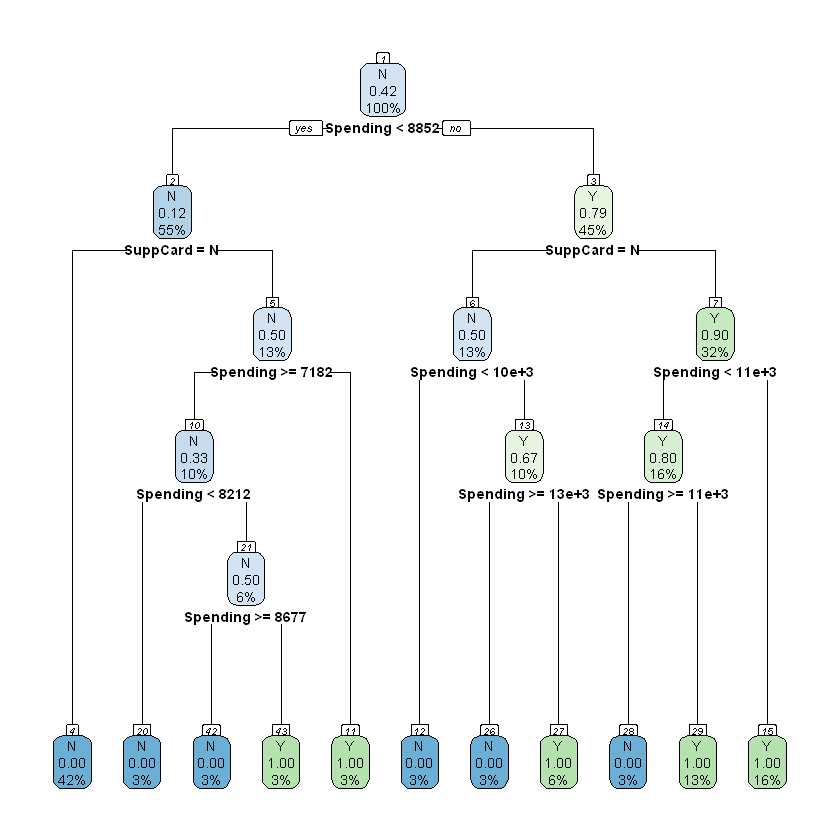

In [5]:
# Create & Plot Maximal CART Tree
cust.cart <- rpart(Upgrade~., data=cust.dt, method="class", 
                   control=rpart.control(minsplit=2,cp=0)) # Categorical Y: "class", Continuous Y: "anova"
rpart.plot(cust.cart, nn=T)
print(cust.cart)

- Node 1(Root node): cases=31, error=13, majority class:N, N:58%, Y:42% → 58% of the customer did not upgrade
- Node 2: Spending<8851.5, cases=17, error=2, majority class:N, N:88%, Y:12% → 88% of those that spend <8851.5 did not upgrade
- Node 3: Spending>=8851.5, cases=14, error=3, majority class:Y, N:21%, Y:79% → 79% of those that spend >=8851.5 upgraded


In [6]:
# Pruning sequence and 10-fold cross-validation errors
printcp(cust.cart)


Classification tree:
rpart(formula = Upgrade ~ ., data = cust.dt, method = "class", 
    control = rpart.control(minsplit = 2, cp = 0))

Variables actually used in tree construction:
[1] Spending SuppCard

Root node error: 13/31 = 0.419

n= 31 

      CP nsplit rel error xerror  xstd
1 0.6154      0     1.000  1.000 0.211
2 0.0513      1     0.385  0.692 0.194
3 0.0385      4     0.231  0.769 0.200
4 0.0000     10     0.000  0.846 0.205


- At cp=0: tree is maximal with 10 splits, train set error= 0% of root node error, avg CV error= 84.6% of root node error, 1 standard error= 20.5% of root node error
- At cp=0.0385: after first pruning, the tree has 4 splits, train set error= 23.1% of root node error, avg CV error= 76.9% of root node error, 1 standard error= 20% of root node error
- At cp=0.0513: after second pruning, the tree has 1 splits, train set error= 38.5% of root node error, avg CV error= 69.2% of root node error, 1 standard error= 19.4% of root node error
- At cp=0.6154: after fourth/final pruning, the tree has 0 split (only root node exists), train set error= 100% of root node error, avg CV error= 100% of root node error, 1 standard error= 21.1% of root node error

### To determine the optimal tree:
- Identify the minimum CV error + 1 SE by visualizing from the chart via the plotcp() function
- OR, through manual calculation

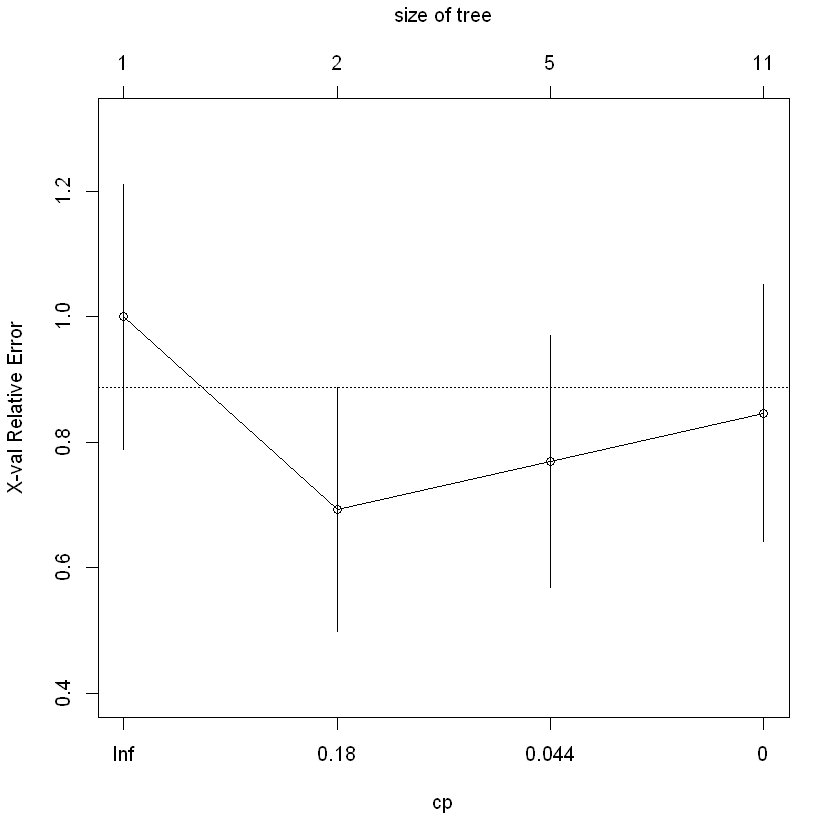

In [7]:
# Display the pruning sequence and 10-fold cross-validation errors in a chart
plotcp(cust.cart)

- The minimum CV error + 1 SE is represented by the dotted horizontal line
- The simplest tree would then be the 2nd tree from the left, with cp=0.18

#### OR, calculate the optimal CP value manually

In [31]:
# Compute min CVerror + 1SE in maximal tree
CVerror.cap <- cust.cart$cptable[which.min(cust.cart$cptable[,"xerror"]), "xerror"] +
  cust.cart$cptable[which.min(cust.cart$cptable[,"xerror"]), "xstd"]

# Find the optimal CP region whose CV error is just below CVerror.cap in maximal tree
i <- 1 ; j <- 4
while (cust.cart$cptable[i,j] > CVerror.cap) {
  i <- i + 1
}

# Get the mean of the 2 identified CP values in the optimal region if optimal tree has at least 1 split
cp.opt = ifelse(i>1, sqrt(cust.cart$cptable[i,1] * cust.cart$cptable[i-1,1]), 1)
cat("The optimal tree is located at the",i,"simplest tree from the left \n")
cat("The optimal CP value is",cp.opt)

The optimal tree is located at the 2 simplest tree from the left 
The optimal CP value is 0.17765


Classification tree:
rpart(formula = Upgrade ~ ., data = cust.dt, method = "class", 
    control = rpart.control(minsplit = 2, cp = 0))

Variables actually used in tree construction:
[1] Spending

Root node error: 13/31 = 0.419

n= 31 

     CP nsplit rel error xerror  xstd
1 0.615      0     1.000  1.000 0.211
2 0.178      1     0.385  0.692 0.194


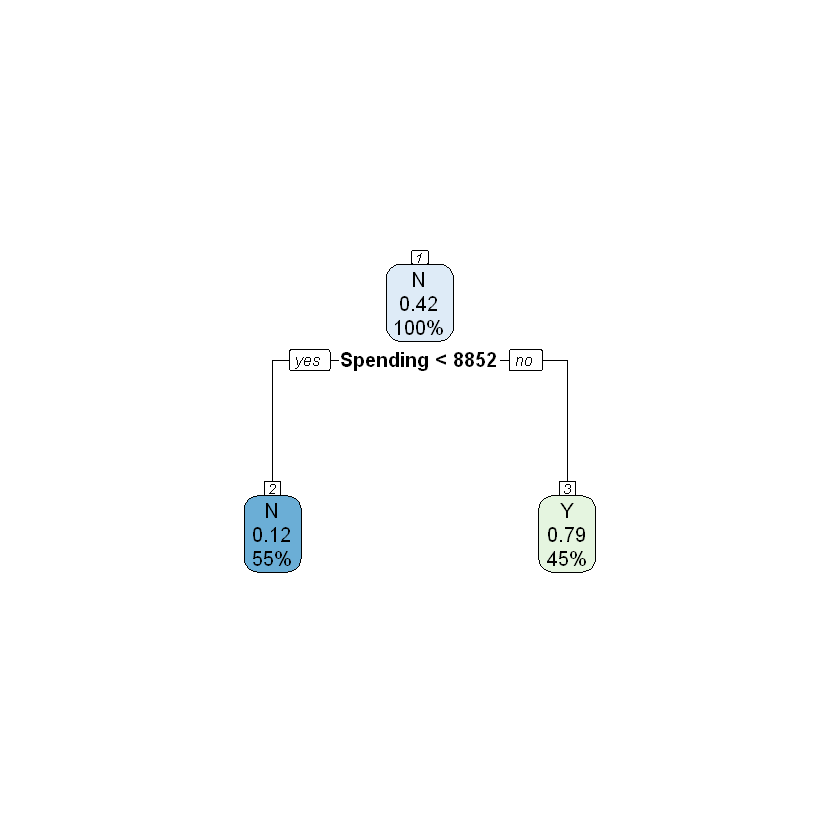

In [9]:
# Get the optimal tree by pruning the maximal tree using the cp value then plot the optimal tree
cust.cart.prune <- prune(cust.cart, cp=cp.opt)
rpart.plot(cust.cart.prune, nn=T)
printcp(cust.cart.prune)

#### Conclusion
The optimal CART model has only 1 decision rule: 
- If annual spending < 8852, then the cardholder is predicted to say No to upgrade offer (88% No, 12% Yes)
- If annual spending >= 8852, then the cardholder is predicted to say Yes to upgrade offer (21% No, 79% Yes)

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

## Continuous Y
### Cart Model for Car Fuel Efficiency

In [10]:
# Read the dataset
data(mtcars)

In [11]:
# Set seed
set.seed(2014)
options(digits=5)

n= 32 

node), split, n, deviance, yval
      * denotes terminal node

  1) root 32 1.1260e+03 20.091  
    2) wt>=2.26 26 3.4657e+02 17.788  
      4) cyl>=7 14 8.5200e+01 15.100  
        8) disp>=450 2 0.0000e+00 10.400 *
        9) disp< 450 12 3.3657e+01 15.883  
         18) hp>=205 5 3.3880e+00 14.620  
           36) qsec>=15.005 3 1.0400e+00 14.100  
             72) drat>=3.48 1 0.0000e+00 13.300 *
             73) drat< 3.48 2 8.0000e-02 14.500  
              146) disp< 400 1 0.0000e+00 14.300 *
              147) disp>=400 1 0.0000e+00 14.700 *
           37) qsec< 15.005 2 3.2000e-01 15.400  
             74) disp< 326 1 0.0000e+00 15.000 *
             75) disp>=326 1 0.0000e+00 15.800 *
         19) hp< 205 7 1.6589e+01 16.786  
           38) disp< 339 5 3.3480e+00 15.920  
             76) hp< 165 2 4.5000e-02 15.350  
              152) disp< 311 1 0.0000e+00 15.200 *
              153) disp>=311 1 0.0000e+00 15.500 *
             77) hp>=165 3 2.2200e+00 16.300  
  

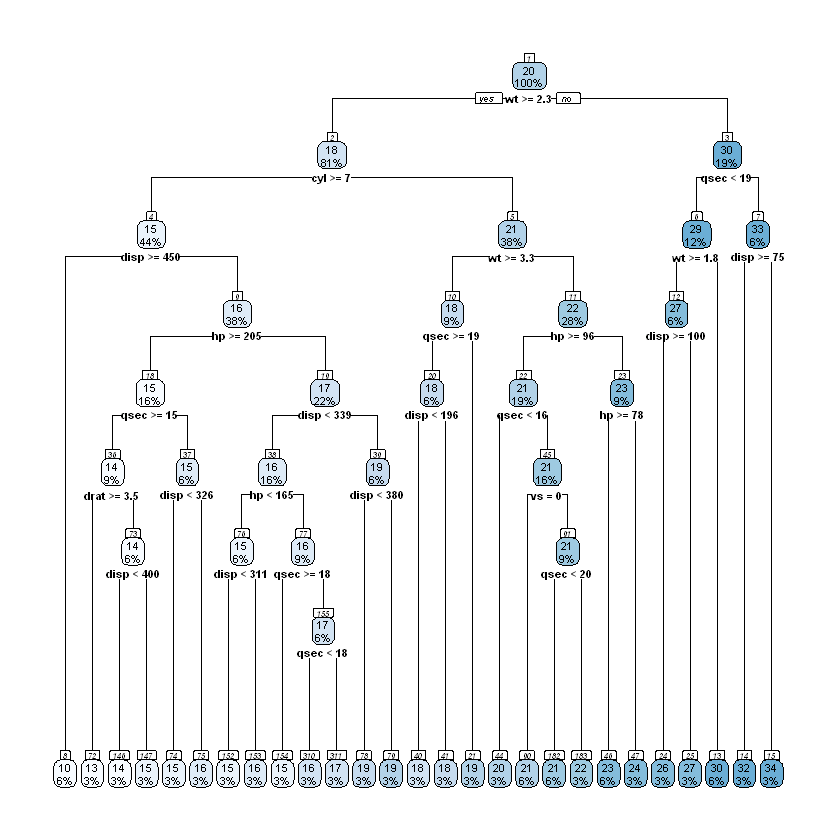

In [17]:
# Create & Plot Maximal CART Tree
cart <- rpart(mpg~., data=mtcars, method="anova",
              control=rpart.control(minsplit=2, cp=0)) # default cp=0.01, so set cp=0
rpart.plot(cart, nn=T)
print(cart)

In [18]:
# Pruning sequence and 10-fold cross-validation errors
printcp(cart)


Regression tree:
rpart(formula = mpg ~ ., data = mtcars, method = "anova", control = rpart.control(minsplit = 2, 
    cp = 0))

Variables actually used in tree construction:
[1] cyl  disp drat hp   qsec vs   wt  

Root node error: 1126/32 = 35.2

n= 32 

         CP nsplit rel error xerror   xstd
1  6.53e-01      0  1.00e+00  1.079 0.2540
2  1.95e-01      1  3.47e-01  0.652 0.1608
3  4.58e-02      2  1.53e-01  0.373 0.0954
4  2.53e-02      3  1.07e-01  0.312 0.0921
5  2.32e-02      4  8.15e-02  0.292 0.0846
6  1.25e-02      5  5.83e-02  0.257 0.0715
7  1.21e-02      6  4.58e-02  0.223 0.0673
8  1.16e-02      7  3.36e-02  0.223 0.0673
9  9.67e-03      8  2.20e-02  0.223 0.0673
10 1.80e-03      9  1.23e-02  0.206 0.0668
11 1.80e-03     10  1.05e-02  0.220 0.0750
12 1.52e-03     11  8.73e-03  0.220 0.0750
13 1.29e-03     12  7.21e-03  0.225 0.0753
14 9.99e-04     14  4.64e-03  0.230 0.0750
15 9.25e-04     15  3.64e-03  0.234 0.0752
16 8.53e-04     16  2.71e-03  0.237 0.0750
17 7.50e-04  

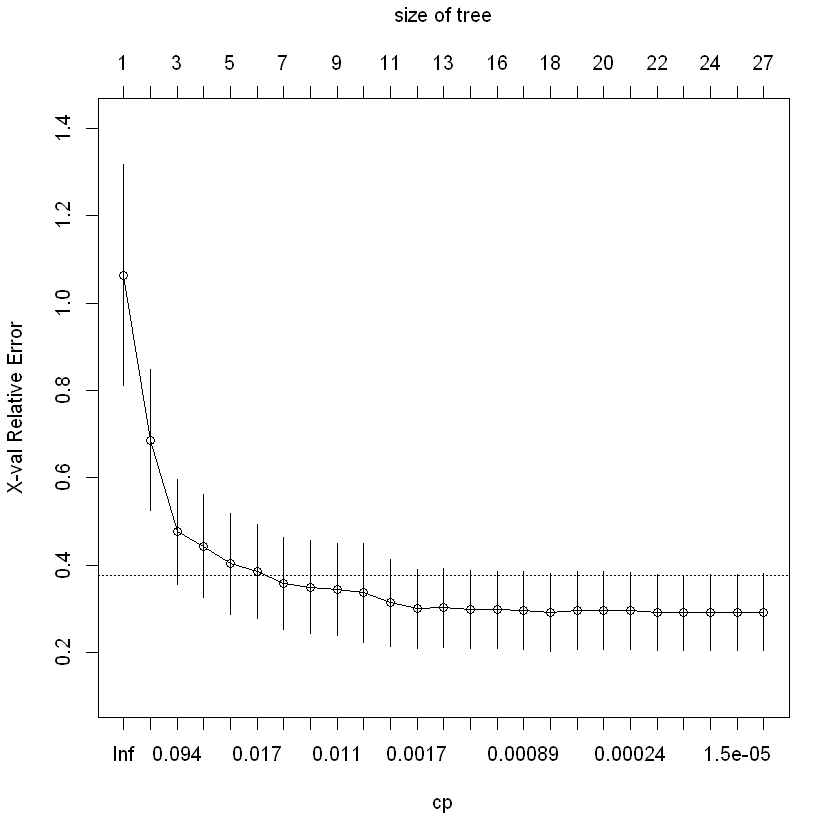

In [14]:
# Display the pruning sequence and 10-fold cross-validation errors in a chart
plotcp(cart)

- The minimum CV error + 1 SE is represented by the dotted horizontal line
- The simplest tree would then be the 6th tree from the right, with cp=~0.016

#### OR, calculate the optimal CP value manually

In [32]:
# Compute min CVerror + 1SE in maximal tree
CVerror.cap <- cart$cptable[which.min(cart$cptable[,"xerror"]), "xerror"] +
  cart$cptable[which.min(cart$cptable[,"xerror"]), "xstd"]

# Find the optimal CP region whose CV error is just below CVerror.cap in maximal tree
i <- 1 ; j <- 4
while (cart$cptable[i,j] > CVerror.cap) {
  i <- i + 1
}

# Get the mean of the 2 identified CP values in the optimal region if optimal tree has at least 1 split
cp.opt = ifelse(i>1, sqrt(cart$cptable[i,1] * cart$cptable[i-1,1]), 1)
cat("The optimal tree is located at the",i,"simplest tree from the left \n")
cat("The optimal CP value is", cp.opt)

The optimal tree is located at the 6 simplest tree from the left 
The optimal CP value is 0.01704

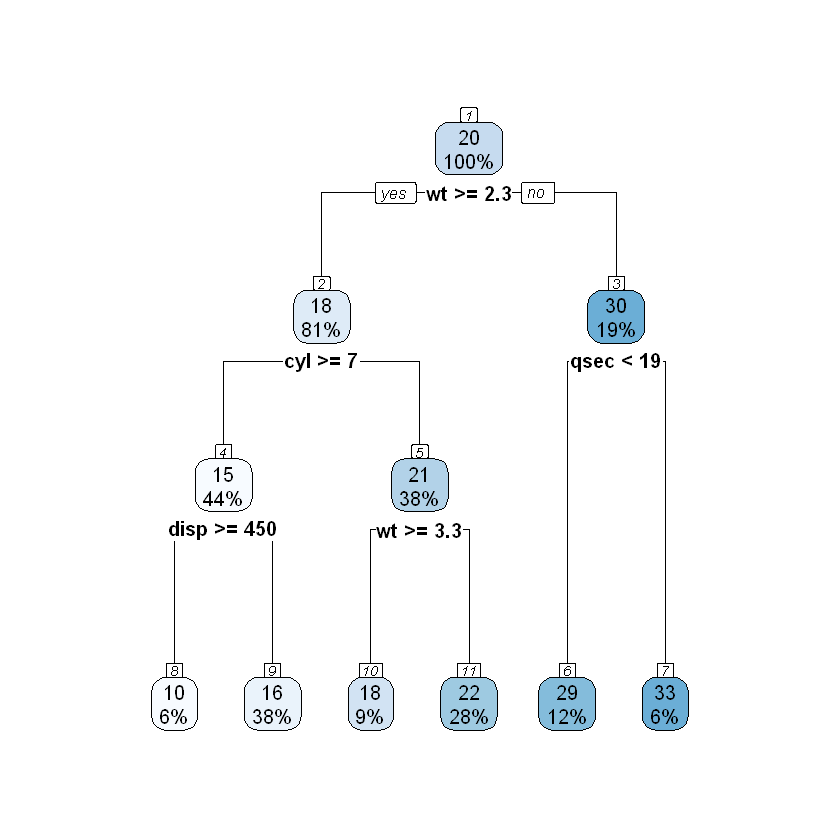

In [34]:
# Get the optimal tree by pruning the maximal tree using the cp value then plot the optimal tree
cart.prune <- prune(cart, cp=cp.opt)
rpart.plot(cart.prune, nn=T)

#### Conclusion
The optimal CART model shows 5 decision rules: 
- The highest estimated average mpg of 33 miles per gallon (node 7) occurs when wt<2.3 and qsec>=19
- The lowest estimated average mpg of 10 miles per gallon (node 8) occurs when wt>=2.3, cyl>=7 and disp>=450